# Info

- building a baseline model using cats vs. dogs architecture, modified by the addition of 2 dropout layers as advised by Omer.
- this baseline model includes a preprocessing steps of rescaling of all images to 448x448 size with a single channel (gray scale)
- this baseline model is built for multi-label classification:
    - output layer has a Sigmoid activation function 
    - loss function is binary_crossentropy
    - chosen metrics is AUC with multi-label parameter set to True (as compatible with the competition requirements)

# Setup

## import libraries and modules

In [142]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import cv2
import os
import numpy as np
from pathlib import Path
from multiprocessing import Pool
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import classification_report, roc_curve, auc
from scipy import interp
%matplotlib inline

## set constants

In [82]:
# input files and directories
TRAIN_META = 'train.csv'
TRAIN_IMG_DIR = Path('train')
TEST_IMG_DIR = Path('test')

# output files and directories
BASE = Path('BaseLine/')
TRAIN_RESIZE_DIR =  BASE / 'train_resize'
TEST_RESIZE_DIR = BASE / 'test_resize'
MODEL_CHECKPOINT = BASE / 'Checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
SERIALIZED =  BASE / 'Serialized'
MODEL =  SERIALIZED / 'model.json'
MODEL_WEIGHTS =  SERIALIZED / 'weights.h5'
MODEL_HISTORY =  SERIALIZED / 'history.pkl'

# generate output directories in case not exist
os.makedirs(TRAIN_RESIZE_DIR, exist_ok=True)
os.makedirs(TEST_RESIZE_DIR, exist_ok=True)
os.makedirs(SERIALIZED, exist_ok=True)

CASE = 'StudyInstanceUID'

# constants for preprocessing
NEW_SIZE = (448,448)
IMG_SIZE = (448, 448, 1)

# parameters for sequential model
RSCL = 1/255
N_FILTERS = 64
FILTER2D_size = 1
ACTIVATION = 'relu'
RATE = 0.5
DENSE_DIM = 64
OUT_ACTIVATION = 'sigmoid'

# parameters for callbacks

MONITOR = 'val_loss'
PATIENCE = 2

# parameters for compilation
METRICS=[AUC(multi_label=True), Precision(), Recall()]
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'

# parameters for fitting
EPOCHS = 100
BATCH_SIZE = 32

# general
RANDOM_STATE = 42
TEST_VALIDATION_SIZE = 0.2
AVAIL_CPU = None

np.random.seed(RANDOM_STATE)

## load meta file

In [4]:
df = pd.read_csv(TRAIN_META)

## get labels

In [5]:
labels = df.select_dtypes(int).columns

## functions

In [10]:
def show_img(img: np.array, axes=None, title: str='', cmap: str = 'gray'):
    if not axes:
        _, axes = plt.subplots()
    axes.imshow(img, cmap=cmap)
    axes.set_title(title)
    
def preprocess(img_path: Path, processed_path: Path, size = NEW_SIZE, 
               scale=cv2.IMREAD_GRAYSCALE):
    new_img = cv2.resize(cv2.imread(str(img_path), scale), size)
    cv2.imwrite(str(processed_path), new_img)
    

def validate_file(record: Path):
    if record.is_file() & record.exists():
        return True
    return False


def numipy_train(meta: pd.DataFrame, img_dir: Path,
                 suffix: str = '.jpg', case_col: str = CASE, 
                 labels_col = labels, 
                 scale=cv2.IMREAD_GRAYSCALE, 
                 image_dir_temp_col = 'images', cpu: int=None):
    
    meta[image_dir_temp_col] = img_dir / (meta[case_col] + suffix)
    msk = meta[image_dir_temp_col].apply(validate_file)
    meta = meta[msk]
    images, label_values = meta[image_dir_temp_col].to_list(), meta[labels_col].values
    images = [(str(image), scale) for image in images]
    with Pool(cpu) as p: images = p.starmap(cv2.imread, images)
    return np.array(images), label_values

def numipy_test(img_dir: Path, suffix: str = '.jpg',
                 scale=cv2.IMREAD_GRAYSCALE, cpu: int=None):
    
    images = list(img_dir.glob('*' + suffix))
    images = [(str(image), scale) for image in images]
    with Pool(cpu) as p: images = p.starmap(cv2.imread, images)
    return np.array(images)
    

def multi_preprocess(input_dir: Path, output_dir: Path, glob: str='*.jpg',
                      size: tuple=NEW_SIZE, scale=cv2.IMREAD_GRAYSCALE, 
                      cpu: int=None):
    pool_lst = []
    os.makedirs(output_dir, exist_ok=True)
    for input_img in input_dir.glob(glob):
        pool_lst.append((input_img, output_dir/input_img.name, size, scale))
    with Pool(cpu) as p: p.starmap(preprocess, pool_lst)


# Preprocess

## preprocess train

In [11]:
multi_preprocess(TRAIN_IMG_DIR, TRAIN_RESIZE_DIR)

## preprocess test

In [12]:
multi_preprocess(TEST_IMG_DIR, TEST_RESIZE_DIR)

## convert train into numpy array

In [13]:
X, y = numipy_train(df, TRAIN_RESIZE_DIR)

## test/train split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_VALIDATION_SIZE, random_state=RANDOM_STATE)

# basic CNN

## make sequential model architecture

In [20]:
model = Sequential([Rescaling(RSCL, input_shape=IMG_SIZE, name='rescaling'),
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_1'), 
                    MaxPooling2D(name='max_pool1'),  
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_2'), 
                    MaxPooling2D(name='max_pool2'), 
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_3'),
                    MaxPooling2D(name='max_pool3'), 
                    Flatten(name='flat'), 
                    Dropout(RATE, name='dropout_1'),
                    Dense(DENSE_DIM, activation=ACTIVATION, name='dense_1'), 
                    Dropout(RATE, name='dropout_2'),
                    Dense(len(labels), activation=OUT_ACTIVATION, name='out')], 
                   name='BaseModel')

## model summary

In [21]:
model.summary()

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 448, 448, 1)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 448, 448, 64)      128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 224, 224, 64)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 224, 224, 64)      4160      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 112, 112, 64)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 112, 112, 64)      4160      
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 56, 56, 64)        0 

## Callbacks

In [28]:
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT, monitor=MONITOR, verbose=1,
save_best_only=True, save_weights_only=False, mode='auto')
callback = EarlyStopping(monitor=MONITOR, patience=PATIENCE)

## compile model

In [29]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# train

In [32]:
model.fit(X_train, y_train, validation_split=TEST_VALIDATION_SIZE, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint, callback])

Epoch 1/100
602/602 [==============================] - 1168s 2s/step - loss: 0.3207 - auc_2: 0.6092 - precision: 0.6128 - recall: 0.4281 - val_loss: 0.2761 - val_auc_2: 0.7111 - val_precision: 0.7131 - val_recall: 0.4384

Epoch 00001: val_loss improved from inf to 0.27610, saving model to BaseLine/Checkpoint/weights.01-0.28.hdf5
Epoch 2/100
602/602 [==============================] - 1175s 2s/step - loss: 0.2846 - auc_2: 0.6631 - precision: 0.6919 - recall: 0.4550 - val_loss: 0.2706 - val_auc_2: 0.6910 - val_precision: 0.7138 - val_recall: 0.4501

Epoch 00002: val_loss improved from 0.27610 to 0.27059, saving model to BaseLine/Checkpoint/weights.02-0.27.hdf5
Epoch 3/100
602/602 [==============================] - 1182s 2s/step - loss: 0.2790 - auc_2: 0.6787 - precision: 0.6917 - recall: 0.4629 - val_loss: 0.2670 - val_auc_2: 0.6916 - val_precision: 0.7068 - val_recall: 0.4849

Epoch 00003: val_loss improved from 0.27059 to 0.26697, saving model to BaseLine/Checkpoint/weights.03-0.27.hdf5

# serialize model, weights and history

In [83]:
model_json = model.to_json()
with open(str(MODEL), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(str(MODEL_WEIGHTS))
with open(str(MODEL_HISTORY), 'wb') as pkl:
    pickle.dump(model.history.history, pkl)

# Evaluation

## AUC plot

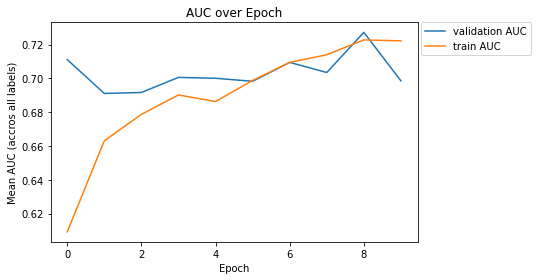

In [60]:
plt.plot(model.history.epoch, model.history.history['val_auc_2'], label='validation AUC')
plt.plot(model.history.epoch, model.history.history['auc_2'], label='train AUC')
plt.title('AUC over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean AUC (across all labels)')
plt.tight_layout()
plt.legend(loc=(1.01,0.85))
plt.show()

## LOSS plot

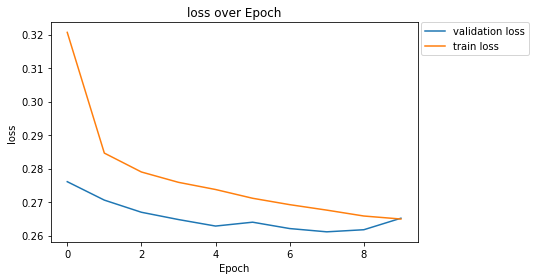

In [61]:
plt.plot(model.history.epoch, model.history.history['val_loss'], label='validation loss')
plt.plot(model.history.epoch, model.history.history['loss'], label='train loss')
plt.title('loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.legend(loc=(1.01,0.85))
plt.show()

## ROC

### predict

In [62]:
y_pred = model.predict(X_test)

### setting 0.5 threshold

In [95]:
y_predicted_label = np.where(y_pred<0.5, 0, 1)

### plotting - each label separately

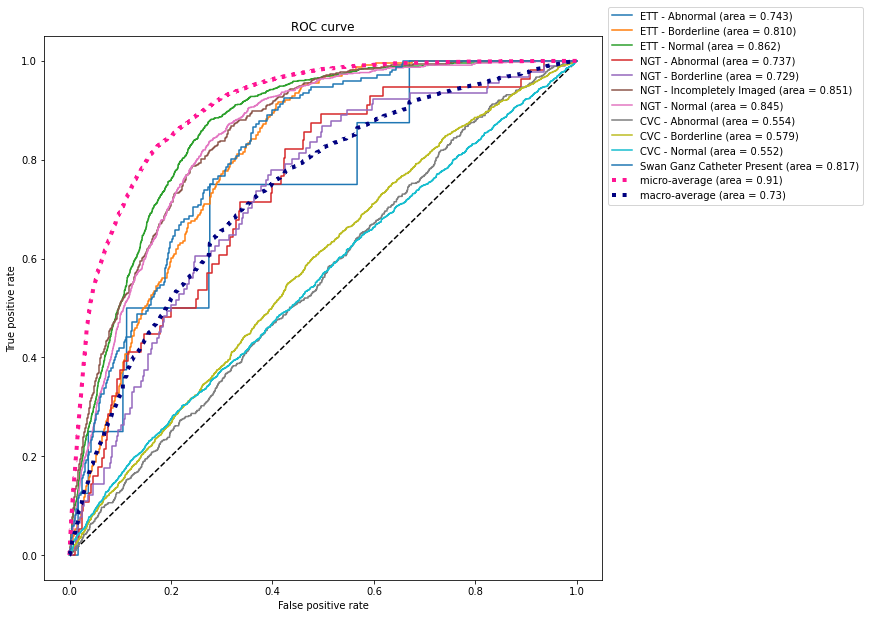

In [159]:
_, ax = plt.subplots(figsize=(10,10))
ax.plot([0, 1], [0, 1], 'k--')
fprs, tprs = [], []
n_classes = len(labels)

fpr_sum, tpr_sum = 0, 0
for i, label in enumerate(labels):
    label_fpr, label_tpr, thresh = roc_curve(y_test[:, i], y_pred[:, i])
    label_auc = auc(label_fpr, label_tpr)
    ax.plot(label_fpr, label_tpr, label='{} (area = {:.3f})'.format(label, label_auc))
    fprs.append(label_fpr)
    tprs.append(label_tpr)

     
# micro 
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

ax.plot(fpr_micro, tpr_micro,
         label='micro-average (area = {0:0.2f})'.format(auc_micro), 
        color='deeppink', linestyle=':', linewidth=4)
    
# macro 
all_fpr = np.unique(np.concatenate(fprs))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fprs[i], tprs[i])
mean_tpr/=n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
auc_macro = auc(fpr_macro, tpr_macro)

ax.plot(fpr_macro, tpr_macro, 
        label='macro-average (area = {0:0.2f})'.format(auc_macro),
         color='navy', linestyle=':', linewidth=4)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=(1.01,0.69))
plt.show()

## classification report

In [94]:
print(classification_report(y_test, y_predicted_label, target_names=labels))

                            precision    recall  f1-score   support

            ETT - Abnormal       0.00      0.00      0.00         8
          ETT - Borderline       0.00      0.00      0.00       228
              ETT - Normal       0.70      0.21      0.33      1432
            NGT - Abnormal       0.00      0.00      0.00        56
          NGT - Borderline       0.00      0.00      0.00        91
 NGT - Incompletely Imaged       0.00      0.00      0.00       548
              NGT - Normal       0.60      0.00      0.01       933
            CVC - Abnormal       0.00      0.00      0.00       642
          CVC - Borderline       0.00      0.00      0.00      1643
              CVC - Normal       0.71      1.00      0.83      4253
Swan Ganz Catheter Present       0.00      0.00      0.00       172

                 micro avg       0.71      0.46      0.55     10006
                 macro avg       0.18      0.11      0.11     10006
              weighted avg       0.46      0.4